In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-poster")
%matplotlib inline

# dy/dt = -ay

In [2]:
def explicit_euler(dydt, h, t_i, y_i):
    return y_i + h*dydt(t_i, y_i)

def rk4(dydt, h, t_i, y_i):
    k1 = dydt(t_i,       y_i)
    k2 = dydt(t_i + h/2, y_i + k1*h/2)
    k3 = dydt(t_i + h/2, y_i + k2*h/2)
    k4 = dydt(t_i + h,   y_i + k3*h)
    return y_i + (k1/6 + k2/3 + k3/3 + k4/6)*h

def abm4(dydt, dydt_2, dydt_1, dydt_0, h, t_3, y_2):
    y_3 = y_2 + h*((23/12)*dydt_2 - (16/12)*dydt_1 + (5/12)*dydt_0) # "Fake" y_3 using AB4.
    return y_2 + h*((9/24)*dydt(t_3, y_3) + (19/24)*dydt_2 - (5/24)*dydt_1 + (1/24)*dydt_0) # "Real" y_3 using AM4.

## Stability computation

In [3]:
from sympy import *
init_printing()
t_i, y_i, a, h = symbols("t_i y_i a h", real=True)
dfdt = lambda t, y: -a*y

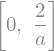

In [4]:
# Explicit euler.
y_next = explicit_euler(dfdt, h, t_i, y_i)
expr = simplify(Abs(y_next/y_i) - 1)
solve(expr, h)

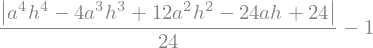

In [5]:
# RK4.
y_next = rk4(dfdt, h, t_i, y_i)
expr = simplify(Abs(y_next/y_i) - 1)
expr

## Step size comparison (a = 5, y0 = 16)

In [ ]:
# ODE to solve: dy/dt = -5y
dfdt = lambda t, y: -5*y

In [ ]:
def euler_plt(h, y0, tmax):
    t = np.arange(0, tmax+h, h)
    y = np.zeros(len(t))
    y[0] = y0
    for i in range(1, len(t)):
        y[i] = explicit_euler(dfdt, h, t[i-1], y[i-1])

    plt.figure(figsize = (20, 8))
    plt.plot(t, y0*np.exp(-5*t), 'g', label="Exact Solution")
    plt.plot(t, y,               'b', label="Explicit Euler (h = " + str(h) + ")")
    plt.xlabel("t (h = " + str(h) + ")")
    plt.ylabel("y(t)")
    plt.grid()
    plt.legend(loc="upper right")
    plt.show()

In [ ]:
y0   = 16
tmax = 2

In [ ]:
euler_plt(0.01, y0, tmax)
euler_plt(0.05, y0, tmax)
euler_plt(0.1,  y0, tmax)
euler_plt(0.2,  y0, tmax)
euler_plt(0.4,  y0, tmax)
euler_plt(0.5,  y0, tmax)

## Method comparison (a=5, y0=16)

In [ ]:
def method_comparison(h, y0, tmax):
    t = np.arange(0, tmax+h, h)

    # Explicit (forward) euler.
    y_euler    = np.zeros(len(t))
    y_euler[0] = y0

    for i in range(1, len(t)):
        y_euler[i] = explicit_euler(dfdt, h, t[i-1], y_euler[i-1])

    # Runge Kutta 4.
    y_rk4      = np.zeros(len(t))
    y_rk4[0]   = y0

    for i in range(1, len(t)):
        y_rk4[i] = rk4(dfdt, h, t[i-1], y_rk4[i-1])

    # Adams-Bashforth-Moulton 4.
    y_abm4       = np.zeros(len(t))
    y_abm4[0]    = y0
    dydt_abm4    = np.zeros(len(t))
    dydt_abm4[0] = dfdt(t[0], y_abm4[0])

    for i in range(1, 3): # First 2 iterations done in RK4.
        y_abm4[i]    = rk4(dfdt, h, t[i-1], y_abm4[i-1])
        dydt_abm4[i] = dfdt(t[i], y_abm4[i]) # Store relevant derivatives to avoid re-computing.

    for i in range(3, len(t)): # Following iterations done in ABM4.
        y_abm4[i]    = abm4(dfdt, dydt_abm4[i-1], dydt_abm4[i-2], dydt_abm4[i-3], h, t[i], y_abm4[i-1])
        dydt_abm4[i] = dfdt(t[i], y_abm4[i])

    plt.figure(figsize = (20, 8))
    plt.plot(t, y0*np.exp(-5*t), 'g', label="Exact Solution")
    plt.plot(t, y_euler,         'b', label="Explicit Euler")
    plt.plot(t, y_rk4,           'r', label="Runge-Kutta4")
    plt.plot(t, y_abm4,          'y', label="Adams-Bashforth-Moulton4")
    plt.xlabel("t (h = " + str(h) + ")")
    plt.ylabel("y(t)")
    plt.grid()
    plt.legend(loc="upper right")
    plt.show()

In [ ]:
y0   = 16
tmax = 2

method_comparison(0.01, y0, tmax)
method_comparison(0.05, y0, tmax)
method_comparison(0.1,  y0, tmax)
method_comparison(0.2,  y0, tmax)
method_comparison(0.4,  y0, tmax)
method_comparison(0.5,  y0, tmax)